# STEPS for Time Serie Forecasting:
1. Get the data (panda-datareader, yfinance or from a csv file )
2. Choose a feature (close, open )
3. Data prepration , EDA
4. Split the data (to prevent data leakage)
5. Scale the training data (fit_transform)
6. Scale the test data (transform)
7. Build model, compile, fit
8. Predict
9. Evaluate

## Import Libraries & Collect Data


In [107]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers
import seaborn as sns
import matplotlib.pyplot as plt
import copy


In [108]:
data = pd.read_csv('AAPL.csv')

## EDA & Data Preparation

In [109]:
explore_df = copy.deepcopy(data)

In [110]:
explore_df.head()

,Date,Open,High,Low,Close,Adj. Close,Volume
0,26-Feb-2021,122.59,124.85,121.20,121.26,121.26,"16,43,20,000"
1,25-Feb-2021,124.68,126.46,120.54,120.99,120.99,"14,73,06,500"
2,24-Feb-2021,124.94,125.56,122.23,125.35,125.35,"11,06,91,500"
3,23-Feb-2021,123.76,126.71,118.39,125.86,125.86,"15,78,59,100"
4,22-Feb-2021,128.01,129.72,125.60,126.00,126.00,"10,36,07,600"


In [111]:
explore_df.tail()

,Date,Open,High,Low,Close,Adj. Close,Volume
9795,09-Aug-1982,0.06,0.06,0.06,0.06,0.04,"5,61,12,000"
9796,06-Aug-1982,0.06,0.06,0.05,0.05,0.04,"9,68,35,200"
9797,05-Aug-1982,0.06,0.06,0.06,0.06,0.04,"6,97,53,600"
9798,04-Aug-1982,0.06,0.06,0.06,0.06,0.05,"8,38,65,600"
9799,03-Aug-1982,0.06,0.06,0.06,0.06,0.05,"8,98,68,800"


In [112]:
explore_df.sample(5)

,Date,Open,High,Low,Close,Adj. Close,Volume
1926,19-Aug-2013,18.01,18.35,18.00,18.13,16.06,"51,05,18,400"
3611,13-Dec-2006,3.14,3.18,3.11,3.18,2.74,"85,70,52,000"
8824,11-Jun-1986,0.16,0.16,0.16,0.16,0.13,"18,68,60,800"
1008,21-Mar-2017,35.53,35.70,34.93,34.96,33.20,"15,81,19,600"
3943,19-Aug-2005,1.65,1.67,1.63,1.64,1.41,"37,65,69,200"


In [113]:
explore_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        9800 non-null   object 
 1   Open        9800 non-null   object 
 2   High        9725 non-null   float64
 3   Low         9725 non-null   float64
 4   Close       9725 non-null   float64
 5   Adj. Close  9725 non-null   float64
 6   Volume      9725 non-null   object 
dtypes: float64(4), object(3)
memory usage: 536.1+ KB


In [114]:
explore_df.isnull().sum()

,0
Date,0
Open,0
High,75
Low,75
Close,75
Adj. Close,75
Volume,75


In [115]:
# Drop Null rows
explore_df.dropna(inplace=True)

In [116]:
# change datatype and format
explore_df['Date'] = pd.to_datetime(explore_df['Date'])
explore_df['Volume'] = explore_df['Volume'].str.replace(',', '')
explore_df = explore_df.astype({'Open': float, 'Volume':float})

In [117]:
explore_df = explore_df.sort_values(by = 'Date', ignore_index = True)

In [118]:
# Drop rows having Date < '2015-01-01'
explore_df = explore_df[explore_df['Date'] >= '2015-01-01'].reset_index(drop = True)

In [119]:
explore_df.describe()

,Date,Open,High,Low,Close,Adj. Close,Volume
count,1549,1549.000000,1549.000000,1549.000000,1549.000000,1549.000000,1.549000e+03
mean,2018-01-29 03:26:22.698515200,50.160265,50.700723,49.618696,50.182447,48.781143,1.449887e+08
min,2015-01-02 00:00:00,22.500000,22.920000,22.370000,22.580000,21.130000,4.544800e+07
25%,2016-07-18 00:00:00,30.000000,30.130000,29.810000,29.990000,27.910000,9.667000e+07
50%,2018-01-30 00:00:00,42.020000,42.550000,41.630000,42.100000,40.600000,1.272076e+08
75%,2019-08-14 00:00:00,55.100000,55.710000,54.370000,55.170000,53.980000,1.731832e+08
max,2021-02-26 00:00:00,143.600000,145.090000,141.370000,143.160000,142.950000,6.488252e+08
std,NaN,28.029971,28.433917,27.552589,28.007536,28.560715,7.095025e+07


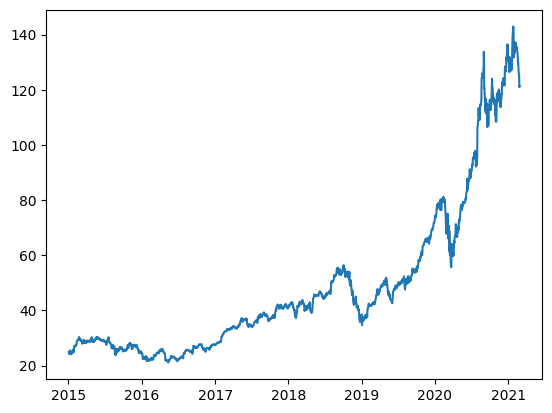

In [120]:
plt.plot(explore_df["Date"], explore_df["Adj. Close"])

In [121]:
df_filtered = explore_df[explore_df["Date"]>= "2020-01-01"]

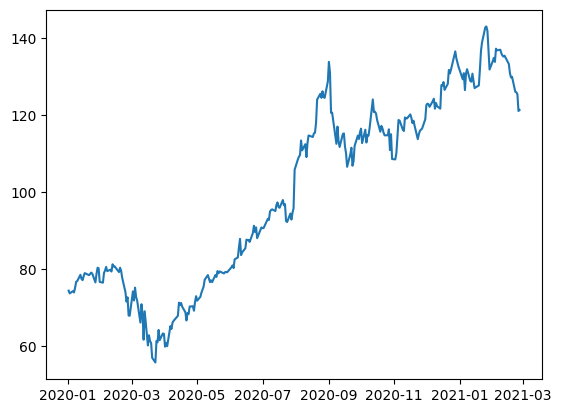

In [122]:
plt.plot(df_filtered['Date'], df_filtered["Adj. Close"])

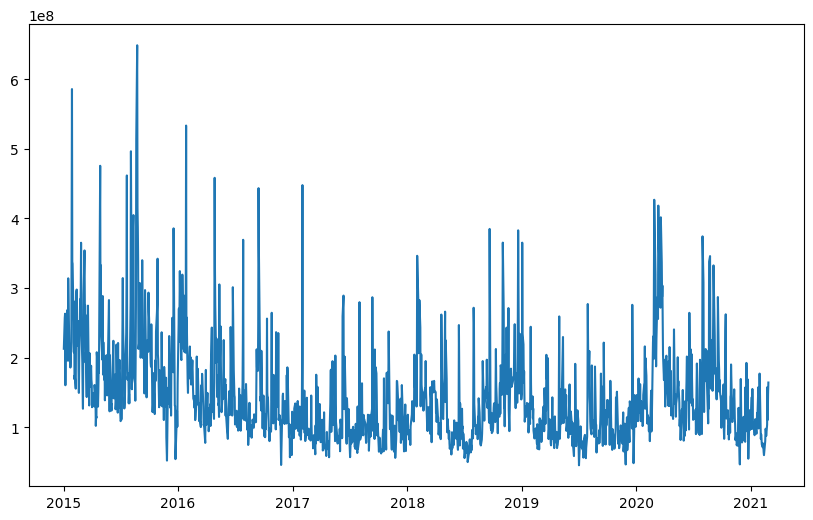

In [123]:
# Volume traded each day
plt.figure(figsize = (10,6))
plt.plot(explore_df['Date'],explore_df['Volume'])

In [124]:
moving_average_day = [10, 20, 50]
for moving in moving_average_day:
  column_name = f"Moving Average for {moving} days"
  explore_df[column_name] = explore_df['Adj. Close'].rolling(moving).mean()

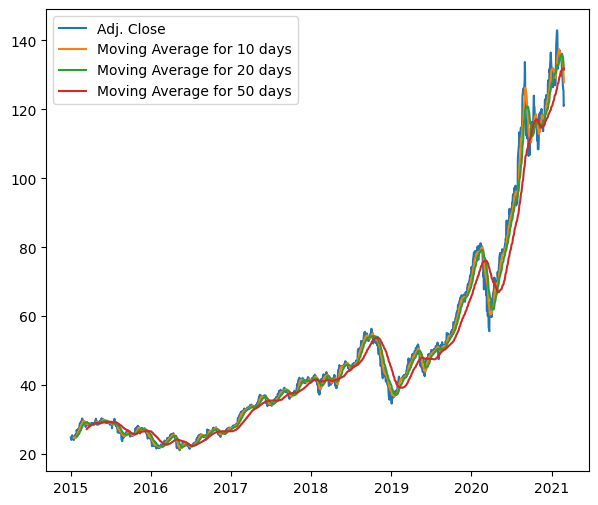

In [125]:
plt.figure(figsize=(7,6))
plt.plot(explore_df["Date"], explore_df["Adj. Close"])
plt.plot(explore_df["Date"], explore_df["Moving Average for 10 days"])
plt.plot(explore_df["Date"], explore_df["Moving Average for 20 days"])
plt.plot(explore_df["Date"], explore_df["Moving Average for 50 days"])
plt.legend(("Adj. Close", "Moving Average for 10 days", "Moving Average for 20 days", "Moving Average for 50 days"))

In [126]:
explore_df['Daily Return'] = explore_df['Adj. Close'].pct_change()

Text(0, 0.5, 'Daily Return')

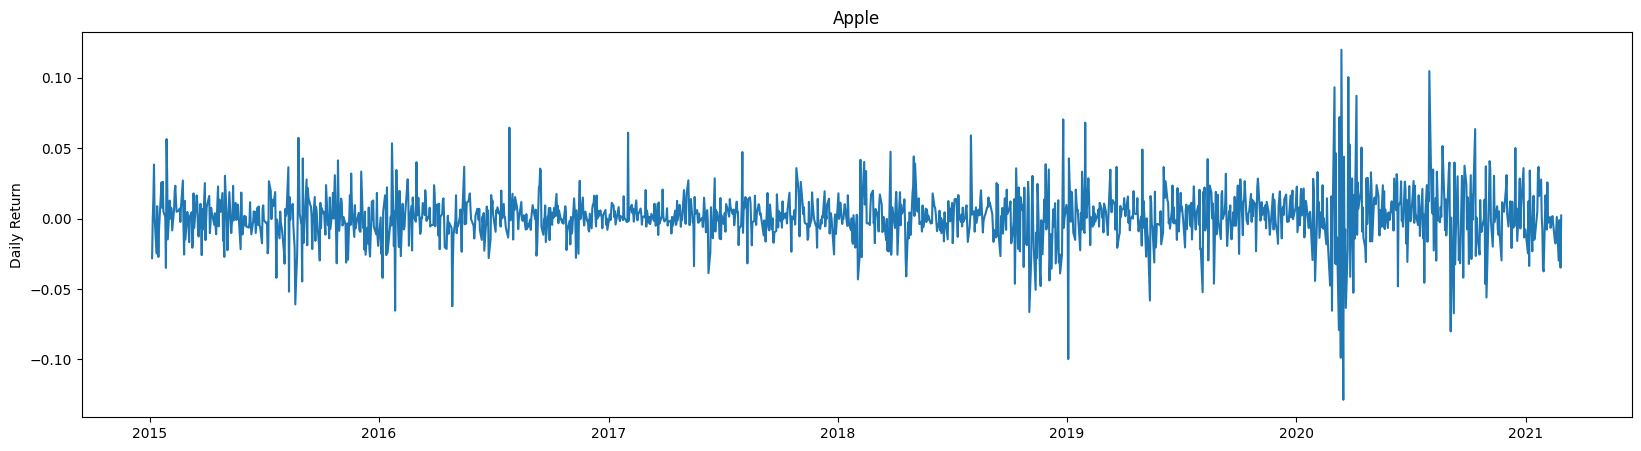

In [127]:
plt.figure(figsize=(20, 5))
plt.plot(explore_df["Date"], explore_df['Daily Return'])
plt.title('Apple')
plt.ylabel('Daily Return')

<ipython-input-128-a7dae5bfcaa2>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(explore_df['Daily Return'].dropna())


<Axes: xlabel='Daily Return', ylabel='Density'>

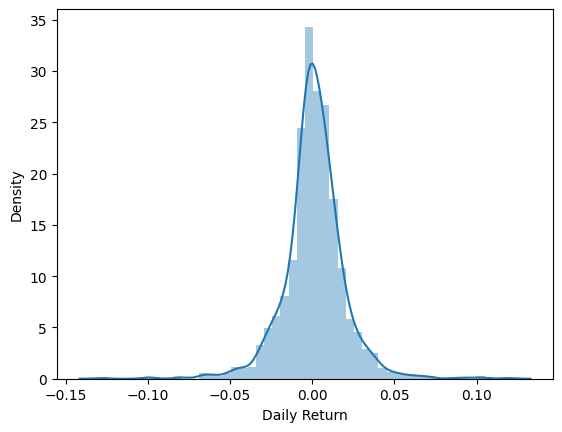

In [128]:
sns.distplot(explore_df['Daily Return'].dropna())

In [129]:
explore_df['Daily Return'].kurtosis()

6.405686938843391

## Data splitting


In [171]:
def create_dataset(data, start_date, time_step=1):
    scaler = MinMaxScaler(feature_range=(0, 1))

    # Split data into training and testing sets
    train_data = data['Adj. Close'][data['Date'] < start_date].to_numpy()
    test_data = data['Adj. Close'][data['Date'] >= start_date].to_numpy()

    # Fit scaler on training data only
    scaler = scaler.fit(train_data.reshape(-1, 1))

    # Create sequences ensuring consistent shapes
    def create_sequences(data, time_step):
        sequences = []
        for i in range(len(data) - time_step):
            sequences.append(data[i:i + time_step])
        return np.array(sequences)

    # Prepare training data
    train_sequences = create_sequences(train_data, time_step)
    train_sequences = scaler.transform(train_sequences.reshape(-1, 1)).reshape(-1, time_step)
    train_x = train_sequences[:-1]
    train_y = train_sequences[1:]

    # Prepare testing data
    test_sequences = create_sequences(test_data, time_step)
    test_sequences = scaler.transform(test_sequences.reshape(-1, 1)).reshape(-1, time_step)
    test_x = test_sequences[:-1]
    test_y = test_sequences[1:]

    return (train_x.reshape(-1, time_step, 1),
            train_y.reshape(-1, time_step, 1),
            test_x.reshape(-1, time_step, 1),
            test_y.reshape(-1, time_step, 1),
            scaler)

In [172]:
AAPL_Date = '2020-10-01'
train_x_data, train_y_data, test_x_data, test_y_data, scaler  = create_dataset(explore_df, AAPL_Date, 5)

In [173]:
print(train_x_data.shape)  # Expected: (n_samples, time_step, 1)
print(train_y_data.shape)  # Expected: (n_samples, time_step, 1)
print(test_x_data.shape)
print(test_y_data.shape)


(1441, 5, 1)
(1441, 5, 1)
(96, 5, 1)
(96, 5, 1)


## Building LSTM model.

In [174]:
def Model():
    model = Sequential([
        # Reduce complexity and add regularization
        LSTM(100, input_shape=(5, 1), activation='relu',
             return_sequences=True,
             kernel_regularizer=regularizers.l2(0.01)),  # Add L2 regularization
        Dropout(0.2),  # Add dropout

        LSTM(50, activation='relu',
             kernel_regularizer=regularizers.l2(0.01)),
        Dropout(0.2),

        Dense(25, activation='relu',
              kernel_regularizer=regularizers.l2(0.01)),
        BatchNormalization(),  # Add batch normalization

        Dense(1)  # Output layer
    ])
    return model


In [175]:
model = Model()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


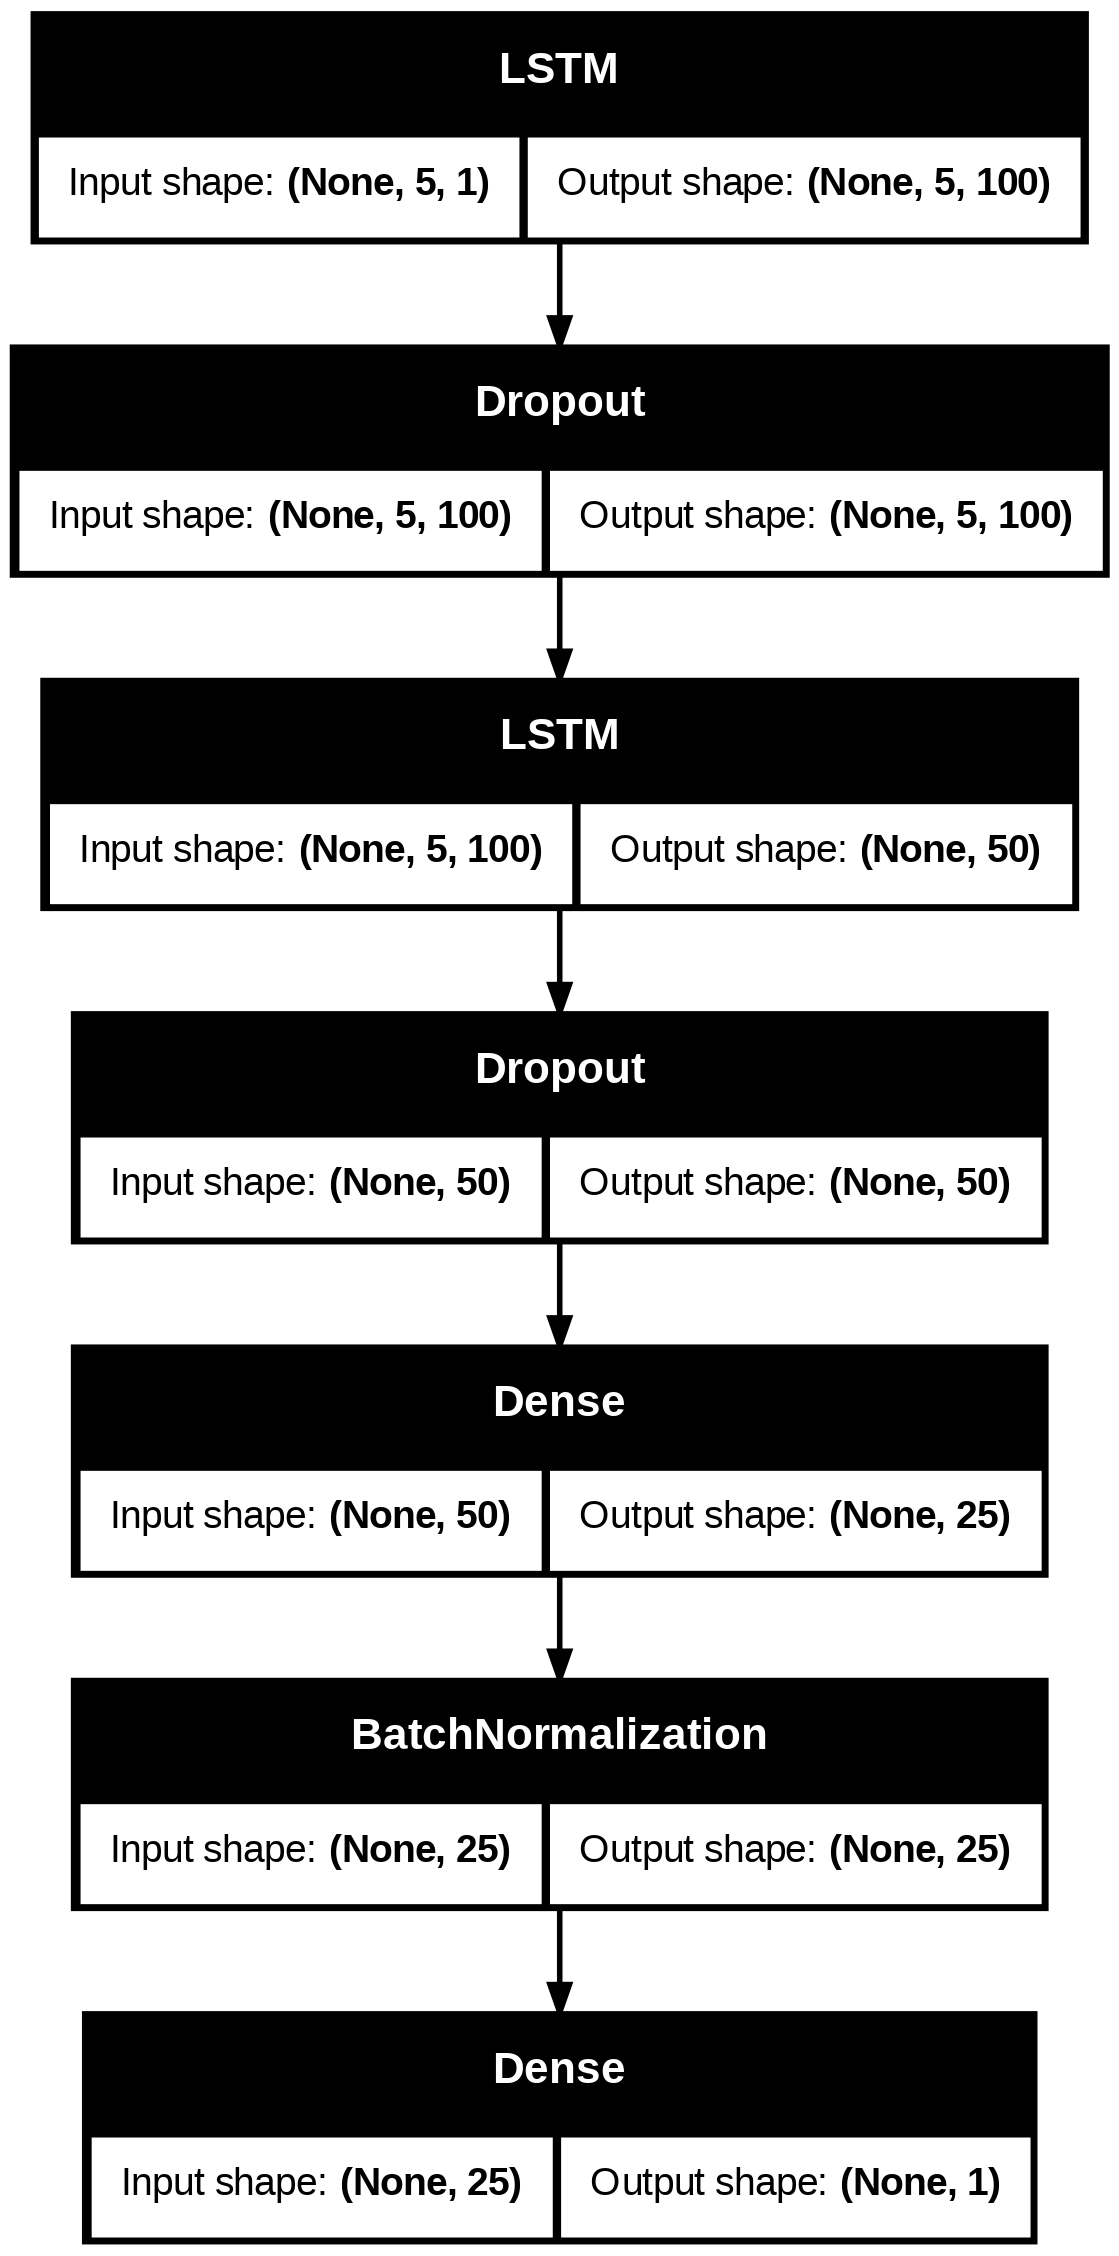

In [176]:
tf.keras.utils.plot_model(model, show_shapes = True)

In [177]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                       │ (None, 5, 100)              │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 5, 100)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_13 (LSTM)                       │ (None, 50)                  │          30,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 25)                  │             100 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 72,401 (282.82 KB)

 Trainable params: 72,351 (282.62 KB)

 Non-trainable params: 50 (200.00 B)

## Learning rate scheduler

In [178]:
import math

def scheduler(epoch):
    """
    Custom learning rate scheduler to adjust the learning rate dynamically during training.

    Parameters:
    epoch (int): Current epoch number during training.

    Returns:
    float: Learning rate for the given epoch.
    """
    initial_lr = 1e-3
    decay_rate = 0.1
    decay_steps = 50

    if epoch < 10:  # Warm-up phase
        return initial_lr * (epoch + 1) / 10
    else:
        return initial_lr * math.exp(-decay_rate * (epoch // decay_steps))


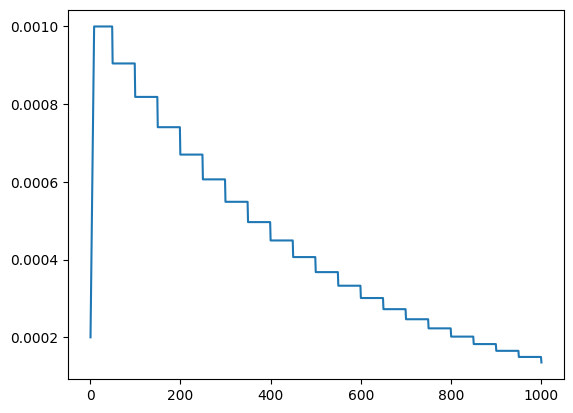

In [179]:
epochs = [i for i in range(1, 1001, 1)]
lrate = [scheduler(i) for i in range(1, 1001, 1)]
plt.plot(epochs, lrate)

## Training

In [180]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5
    )
]

In [181]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [182]:
history = model.fit(
    train_x_data,
    train_y_data,
    epochs=100,
    batch_size=32,  # Add appropriate batch size
    validation_data=(test_x_data, test_y_data),
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 1.4009 - root_mean_squared_error: 0.1675 - val_loss: 1.1467 - val_root_mean_squared_error: 0.6882 - learning_rate: 0.0010
Epoch 2/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.5460 - root_mean_squared_error: 0.0545 - val_loss: 0.7490 - val_root_mean_squared_error: 0.6974 - learning_rate: 0.0010
Epoch 3/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.2155 - root_mean_squared_error: 0.0446 - val_loss: 0.5814 - val_root_mean_squared_error: 0.6878 - learning_rate: 0.0010
Epoch 4/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0919 - root_mean_squared_error: 0.0444 - val_loss: 0.4822 - val_root_mean_squared_error: 0.6576 - learning_rate: 0.0010
Epoch 5/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0442 - root_mean_squared_error: 0.0438 - val_loss: 0.4408 - val_root_mean_squared_error: 0.6445 - learning_rate: 0.0010
Epoch 6/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0257 - root_mean_squared_err

## Evaluation

In [183]:
hist = history.history
loss = hist["loss"]
root_mean_squared_error = hist["root_mean_squared_error"]
val_loss = hist["val_loss"]
val_root_mean_squared_error = hist["val_root_mean_squared_error"]
epochs = range(1, len(loss) + 1)

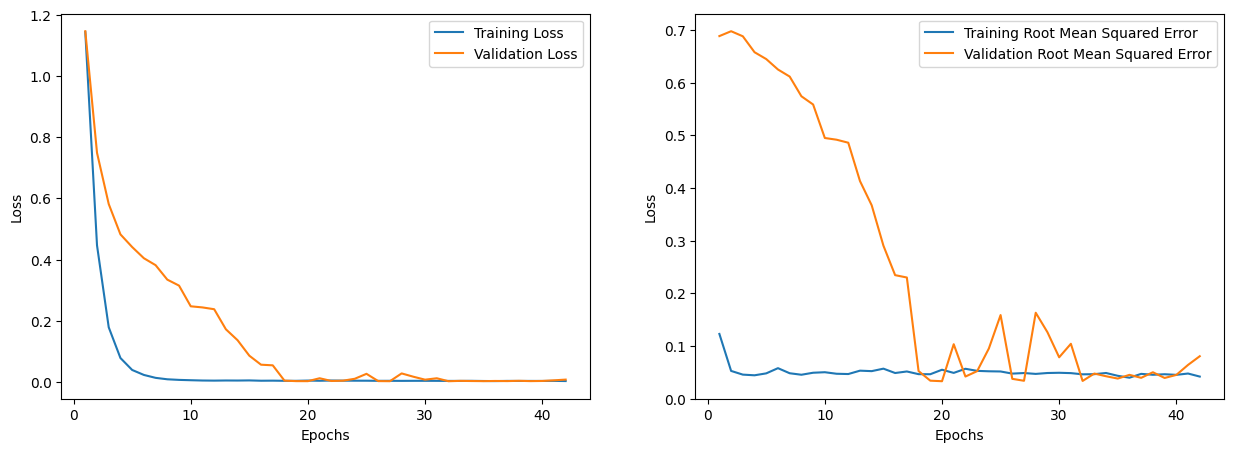

In [184]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(epochs, loss, label = 'Training Loss')
ax1.plot(epochs, val_loss, label = 'Validation Loss')
ax1.set(xlabel = "Epochs", ylabel = "Loss")
ax1.legend()

ax2.plot(epochs, root_mean_squared_error, label = "Training Root Mean Squared Error")
ax2.plot(epochs, val_root_mean_squared_error, label = "Validation Root Mean Squared Error")
ax2.set(xlabel = "Epochs", ylabel = "Loss")
ax2.legend()

plt.show()

In [190]:
print("Predictions shape:", predictions.shape)
print("Test dates shape:", len(explore_df['Date'][explore_df['Date'] >= '2020-10-12']))
print("Test data shape:", len(explore_df['Adj. Close'][explore_df['Date'] >= '2020-10-12']))

Predictions shape: (95, 1)
Test dates shape: 95
Test data shape: 95


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  
Predictions shape after trimming: (95, 1)
Test dates shape: 95


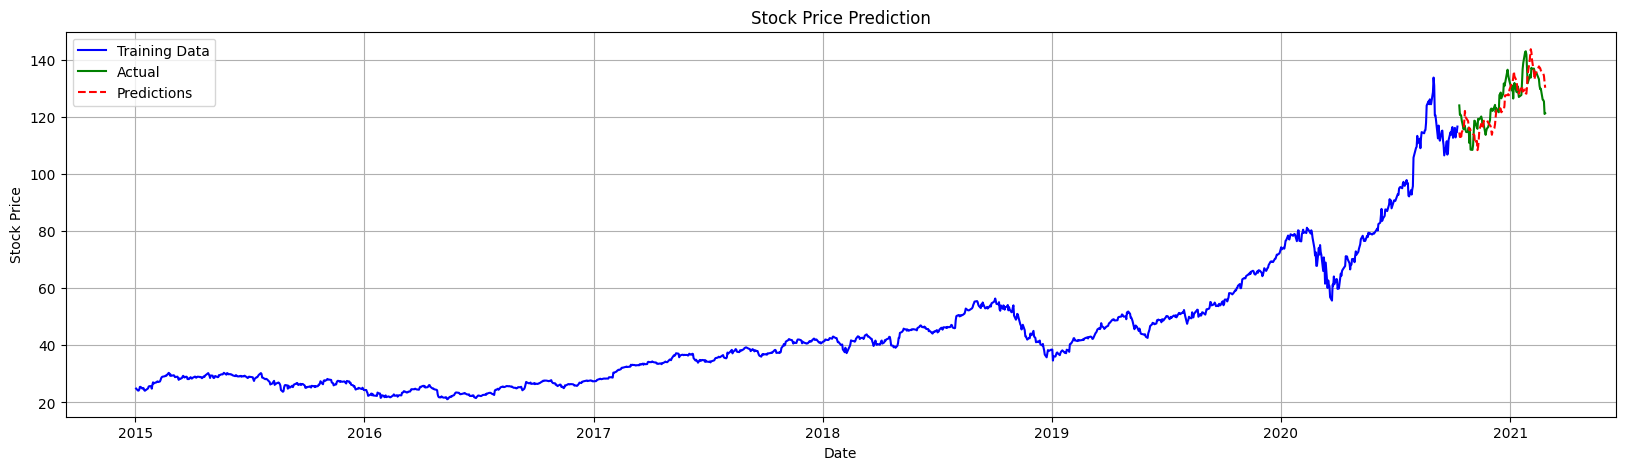

In [186]:
def plot_predictions(df, predictions, start_date, scaler):
    # Ensure predictions match the number of dates
    predictions = predictions[:95]  # Trim predictions to match dates

    # Get the correct dates for plotting
    test_dates = df['Date'][df['Date'] >= start_date].iloc[:len(predictions)]

    plt.figure(figsize=(20, 5))

    # Plot training data
    plt.plot(df['Date'][df['Date'] < start_date],
             df['Adj. Close'][df['Date'] < start_date],
             label='Training Data', color='blue')

    # Plot actual test data
    plt.plot(test_dates,
             df['Adj. Close'][df['Date'] >= start_date].iloc[:len(predictions)],
             label='Actual', color='green')

    # Plot predictions
    plt.plot(test_dates,
             predictions,
             label='Predictions', color='red', linestyle='--')

    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.title('Stock Price Prediction')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

# Make predictions and plot
predictions = model.predict(test_x_data)
predictions = scaler.inverse_transform(predictions.reshape(-1, 1))

# Trim predictions to match dates
predictions = predictions[:95]

# Verify shapes after trimming
print("Predictions shape after trimming:", predictions.shape)
print("Test dates shape:", len(explore_df['Date'][explore_df['Date'] >= '2020-10-12']))

# Plot
plot_predictions(explore_df, predictions, '2020-10-12', scaler)

In [189]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Print shapes for debugging
print("Original shapes:")
print("test_y_data shape:", test_y_data.shape)
print("predictions shape:", predictions.shape)

# Reshape and get the correct number of samples
actual_values = scaler.inverse_transform(test_y_data.reshape(-1, 1))[:95]  # Match with predictions length
predictions = predictions[:95]  # Make sure predictions match actual values length

# Verify shapes after reshaping
print("\nAfter reshaping:")
print("actual_values shape:", actual_values.shape)
print("predictions shape:", predictions.shape)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(actual_values, predictions))
mape = np.mean(np.abs((actual_values - predictions) / actual_values)) * 100

print(f'\nMetrics:')
print(f'RMSE: {rmse:.2f}')
print(f'MAPE: {mape:.2f}%')

# Alternative calculation function with proper shape handling:
def calculate_metrics(y_true, y_pred, scaler):
    # Ensure we're working with the correct shapes
    y_true = y_true.reshape(-1)
    y_pred = y_pred.reshape(-1)

    # Take only the matching length
    min_length = min(len(y_true), len(y_pred))
    y_true = y_true[:min_length]
    y_pred = y_pred[:min_length]

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    return rmse, mape

rmse, mape = calculate_metrics(actual_values, predictions, scaler)
print(f'\nUsing calculation function:')
print(f'RMSE: {rmse:.2f}')
print(f'MAPE: {mape:.2f}%')

Original shapes:
test_y_data shape: (96, 5, 1)
predictions shape: (95, 1)

After reshaping:
actual_values shape: (95, 1)
predictions shape: (95, 1)

Metrics:
RMSE: 13.96
MAPE: 9.58%

Using calculation function:
RMSE: 13.96
MAPE: 9.58%
